# Deep learning on handwritten digits

The MNIST (mixed National Institute of Standards and Technology) dataset ([https://en.wikipedia.org/wiki/MNIST_database](https://en.wikipedia.org/wiki/MNIST_database)) is a classic data set in machine learning. To develop our intuitions about the problem, we start with a simple linear classifier and achieve an average accuracy of $80\%$. We then proceed to build a state-of-the-art convolutional neural network (CNN) and achieve an accuracy of over $98\%$.

This notebook is available on [https://github.com/jcboyd/deep-learning-workshop](https://github.com/jcboyd/deep-learning-workshop).

A Docker image for this project is available on Docker hub:

> $ docker pull jcboyd/deep-learning-workshop/:[cpu|gpu]

> $ nvidia-docker run -it -p 8888:8888 jcboyd/deep-learning-workshop/:[cpu|gpu]

## 1. Machine Learning

* Machine learning involves algorithms that find patterns in data.


* This amounts to a form of *inductive reasoning*: inferring general rules from examples, with the view of reapplying them to new examples. *Learning by example*



* This symbols are labeled (yes/no) $\implies$ *supervised* learning problem


*Murphy, Kevin P. Machine learning: a probabilistic perspective. MIT press, 2012. (Figure 1.1)*

![img/induction.png](img/induction.png)

* The corresponding dataset would look something like the following:

In [1]:
from __future__ import print_function
from __future__ import division

from pandas import read_csv
read_csv(open('data/shapes.csv'))

,Shape,Colour,Label
0,Arrow,Blue,Yes
1,Circle,Red,Yes
2,Star,Yellow,Yes
3,Triangle,Blue,Yes
4,Triangle,Yellow,Yes
5,Arrow,Orange,No
6,Circle,Blue,No
7,Circle,Green,No
8,Circle,Orange,No
9,Square,Orange,No


### 1.1 Classifiers

* The above is an example of a *classification* problem. 


* Each *observation* $\mathbf{x}_i$ is represented by a vector of $D$ dimensions or *features* and has label $y_i$ denoting its class (e.g. yes or no).


* Thus, our dataset of $N$ observations is,

$$\mathcal{D} = \{\mathbf{x}_i, y_i\}_{i=1}^N,$$
$$\mathbf{x}_i \in \mathbb{R}^D, y_i \in \{1, \dots, C\}$$


* The model will attempt to divide the feature space such that the classes are as separate as possible, creating a *decision boundary*.

![img/separation.png](img/separation.png)

### 1.2 Data Exploration

* The MNIST dataset ([https://en.wikipedia.org/wiki/MNIST_database](https://en.wikipedia.org/wiki/MNIST_database)) is a classic dataset in machine learning.


* Derived from a dataset of handwritten characters "crowdsourced" from US high school students.


* It consists of 60,000 labelled images of handwritten digits 0-9, and a test set of a further 10,000 images.


* Notably used as a benchmark in the development of convolutional neural networks.

In [2]:
from keras.datasets import mnist
from sklearn.model_selection import train_test_split

# mnist = mnist.read_data_sets('MNIST_data', reshape=False, one_hot=False)

(Xtr, Ytr), (Xte, Yte) = mnist.load_data()

Xtr, Xval, Ytr, Yval = train_test_split(Xtr, Ytr, test_size=5000)

# Xtr = mnist.train.images
# Ytr = mnist.train.labels

# Xval = mnist.validation.images
# Yval = mnist.validation.labels

# Xte = mnist.test.images
# Yte = mnist.test.labels

print('Training data shape: ', Xtr.shape)
print('Training labels shape: ', Ytr.shape)
print('Validation data shape: ', Xval.shape)
print('Validation labels shape: ', Yval.shape)
print('Test data shape: ', Xte.shape)
print('Test labels shape: ', Yte.shape)

Using TensorFlow backend.


Training data shape:  (55000, 28, 28)
Training labels shape:  (55000,)
Validation data shape:  (5000, 28, 28)
Validation labels shape:  (5000,)
Test data shape:  (10000, 28, 28)
Test labels shape:  (10000,)


* We can visualise our data samples with Python

Class: 3


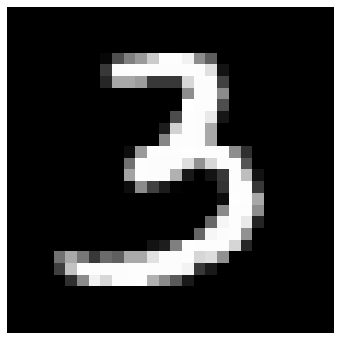

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from src import vis_utils

# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg')

fig, ax = plt.subplots(figsize=(6, 6))
idx = np.random.randint(len(Xtr))
vis_utils.plot_image(ax, Xtr[idx, :, :], Ytr[idx])

* As far as our model will be concerned, the images in the dataset are just vectors of numbers.


* From this perspective, there is no fundamental difference between the MNIST problem, and the symbols problem above.


* The observations just live in 784-dimensional space (28 $\times$ 28 pixels) rather than 2-dimensional space.

In [4]:
print(Xtr[idx].reshape((1, 784))[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   7  79 128 154 203 253
 253 242 141  94   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0  57 252 252 253 252 252 252 253 252 224  19   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0  38 168 168 156
  56  56  56 216 252 252  65   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0 141 252 252 139   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0 255 253 253  78   0   0   0   

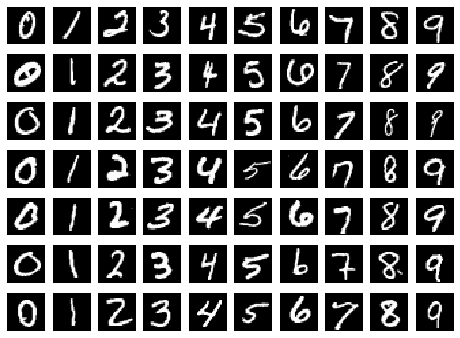

In [5]:
fig = plt.figure(figsize=(8, 6))
vis_utils.plot_array(fig, Xtr, Ytr, num_classes=10)

### 1.3 Data Preprocessing

* For our linear models, we will "flatten" the data for convenience:

In [6]:
# First, vectorise image data
Xtr_rows = np.reshape(Xtr, (Xtr.shape[0], -1)).copy()
Xval_rows = np.reshape(Xval, (Xval.shape[0], -1)).copy()
Xte_rows = np.reshape(Xte, (Xte.shape[0], -1)).copy()

# As a sanity check, print out the shapes of the data
print('Training data shape: ', Xtr_rows.shape)
print('Validation data shape: ', Xval_rows.shape)
print('Test data shape: ', Xte_rows.shape)

Training data shape:  (55000, 784)
Validation data shape:  (5000, 784)
Test data shape:  (10000, 784)


* A typical procedure prior to training is to normalise the data.


* Here we subtract the *mean image*

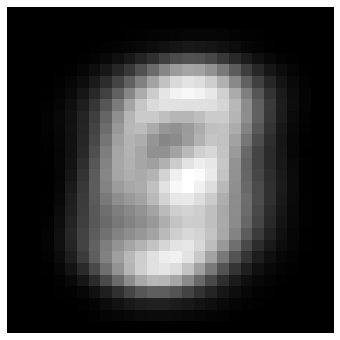

In [7]:
mean_image = np.mean(Xtr, axis=0).reshape(1, 784)

Xtr_rows = Xtr_rows - mean_image
Xval_rows = Xval_rows - mean_image
Xte_rows = Xte_rows - mean_image

fig, ax = plt.subplots(figsize=(6, 6))
vis_utils.plot_image(ax, mean_image.reshape(28, 28))

### 1.2 Linear Classification

* First we will assume a linear *score function*, that is, a prediction that is a linear combination of inputs and model *weights*,

$$f(\mathbf{x} ; \mathbf{w}) = \mathbf{w}^T\mathbf{x} = w_1x_1 + w_2x_2 + \dots + w_Dx_D$$


* For `MNIST`, $D = 784$, and we need a weight for every pixel in an image.


* The choice of model weights will be *inferred* from the data in a procedure called *training*.


*Stanford Computer Vision course--Convolutional Neural Networks for Visual Recognition [http://cs231n.stanford.edu/](http://cs231n.stanford.edu/) *

<div style="text-align:center"><img src ="img/linear.png"/></div>

### 1.3 Model training

* Training involves computing a mathematical function that differentiates between observations from different classes--classifier.


* We first decide on a form for the function $f$ to take, then we optimise its parameters $\mathbf{w}$ over the dataset and a loss function, $\mathcal{L}$,

$$\mathbf{w}^* = \min_{\mathbf{w}} \sum_{i=1}^N \mathcal{L}(f(\mathbf{x}_i ; \mathbf{w}), y_i)$$


* The loss function measures how close the classification $f(\mathbf{x}_i ; \mathbf{w})$ of observations $\mathbf{x}_i$ is to the true value $y_i$.


* Training consists of finding the weights that minimise the loss over the training set.

* The most common procedure for optimising a convex differentiable function is known as *gradient descent*,

$$\mathbf{w}^{(k+1)} = \mathbf{w}^{(k)} - \alpha\nabla\mathcal{L}(\mathbf{w}^{(k)})$$

where $\alpha$ is referred to as the step size or *learning rate*. Thus, each iteration is a descent step, and we converge iteratively to a global minimum.

![img/gradientdescent.png](img/gradientdescent.png)

In [8]:
from src.linear_models import MultiSVM, SoftmaxRegression

# Perform bias trick
Xtr_rows = np.append(Xtr_rows, np.ones((Xtr_rows.shape[0], 1)), axis=1)
Xval_rows = np.append(Xval_rows, np.ones((Xval_rows.shape[0], 1)), axis=1)
Xte_rows = np.append(Xte_rows, np.ones((Xte_rows.shape[0], 1)), axis=1)

reg = 5e4
batch_size = 200
max_iters = 1500
learning_rate = 1e-7

model = SoftmaxRegression(Xtr_rows, Ytr)
model.train(reg, batch_size, learning_rate, max_iters, Xval_rows, Yval)

Step 0 of 1500
Mini-batch loss: 66.41429 Learning rate: 0.00000
Validation error: 0.8676
Step 100 of 1500
Mini-batch loss: 25.42069 Learning rate: 0.00000
Validation error: 0.5324
Step 200 of 1500
Mini-batch loss: 10.46568 Learning rate: 0.00000
Validation error: 0.3246
Step 300 of 1500
Mini-batch loss: 4.98908 Learning rate: 0.00000
Validation error: 0.2648
Step 400 of 1500
Mini-batch loss: 2.95196 Learning rate: 0.00000
Validation error: 0.2456
Step 500 of 1500
Mini-batch loss: 2.23074 Learning rate: 0.00000
Validation error: 0.2344
Step 600 of 1500
Mini-batch loss: 1.91316 Learning rate: 0.00000
Validation error: 0.2298
Step 700 of 1500
Mini-batch loss: 1.86916 Learning rate: 0.00000
Validation error: 0.2280
Step 800 of 1500
Mini-batch loss: 1.82195 Learning rate: 0.00000
Validation error: 0.2300
Step 900 of 1500
Mini-batch loss: 1.80360 Learning rate: 0.00000
Validation error: 0.2286
Step 1000 of 1500
Mini-batch loss: 1.81790 Learning rate: 0.00000
Validation error: 0.2296
Step 110

### 1.4 Model Testing

In [9]:
num_test = Yte.shape[0]
predictions = [model.predict(Xte_rows[i]) for i in range(num_test)]
print('Error: %.02f%%' % (100 * (1 - float(sum(Yte == np.array(predictions))) / num_test)))

Error: 20.73%


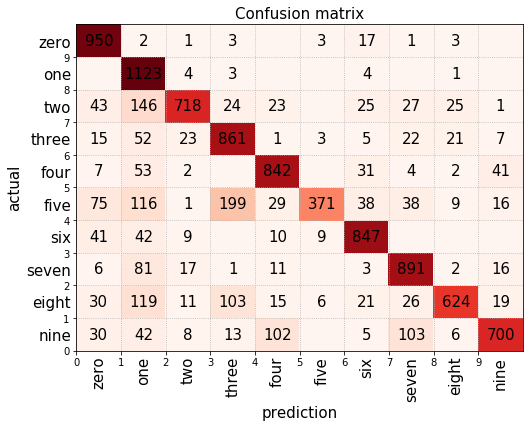

In [10]:
from src.vis_utils import plot_confusion_matrix

num_classes = 10

fig, ax = plt.subplots(figsize=(8, 6))

classes = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

confusion_matrix = np.zeros((num_classes, num_classes), np.int32)

for i in range(len(predictions)):
    confusion_matrix[Yte[i]][predictions[i]] += 1

plot_confusion_matrix(ax, confusion_matrix, classes, fontsize=15)

* Let's look at some of the model's mistakes

Prediction: 6
True class: 5


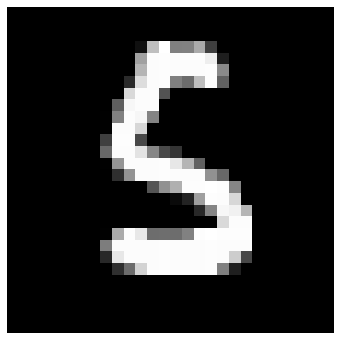

In [13]:
false = np.where(np.not_equal(Yte, predictions))[0]
idx = np.random.choice(false)
print('Prediction: %d\nTrue class: %d' % (predictions[idx], Yte[idx]))

fig, ax = plt.subplots(figsize=(6, 6))
vis_utils.plot_image(ax, Xte[idx])

* In pixel-space, the model had moderate success in separating the image clusters.

![img/normals.png](img/normals.png)

* The optimised weights are those generalising maximally over each of the class observations


* We can take each of the weight vectors and plot them as an image to visualise the template they have learned

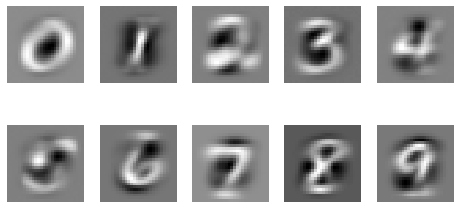

In [14]:
fig = plt.figure(figsize=(8, 4))
vis_utils.plot_weights(fig, model.W[:-1,:], classes)

## 2. Deep Learning

Deep learning is characterised by the modeling of a hierarchy of abstraction in the input data. In the following we focus on applications to images, but note deep learning has seen great success in various fields from natural language processing to speech synthesis.


### 2.1 Features

* Features provide a *representation* of the objects we want to classify. Designing features is arguably the most difficult and most important aspect of machine learning.


* In the above we were operating purely on pixel features. One way we might improve is with *feature engineering* (expert knowledge), *feature extraction* (conventional techniques), *feature selection*, or *dimensionality reduction*.


* Another approach is to create non-linear transformations based on a *kernel function* (see kernel methods).


* Yet another approach is to build the feature learning into the model itself. This is the essence of *representation* or *deep learning*.

### 2.2 Artificial Neural Networks

* Neural networks model hidden layers between input and ouptut, passing through non-linear activation functions.


* Neural networks are particularly amenable to hierarchical learning, as hidden layers are easily stacked.


* (Loosely) inspired by the interaction of neurons in the human brain.


![img/layers.png](img/layers.png)



* Multiclass logistic regression:

$$\mathbf{f}(\mathbf{x}) = \text{softmax}(\mathbf{W}\mathbf{x}  + \mathbf{b})$$

where $\mathbf{W} \in \mathbb{R}^{K \times D}$ are the weights and $\mathbf{b} \in \mathbb{R}^{K \times 1}$ (sometimes incorporated into the weights--bias trick) and $\text{softmax}(x) = \frac{\exp(x)}{\sum_{x'}\exp(x')}$ generalises the sigma logistic function.

* Neural network (one hidden layer):

\begin{align}
\mathbf{h}(\mathbf{x}) &= \sigma(\mathbf{W}^{(1)}\mathbf{x}  + \mathbf{b}^{(1)}) & \text{(hidden layer)} \notag \\
\mathbf{f}(\mathbf{x}) &= \text{softmax}(\mathbf{W}^{(2)}\mathbf{x}  + \mathbf{b}^{(2)}) & \text{(output layer)}\notag
\end{align}


* Deeper network? Just keep stacking!

$$\mathbf{f}(\mathbf{x}) = \sigma(\mathbf{W}^{(M)}\sigma(\mathbf{W}^{(M-1)}(\cdots\sigma(\mathbf{W}^{(1)}\mathbf{x} + \mathbf{b}^{(1)})\cdots)  + \mathbf{b}^{(M-1)})  + \mathbf{b}^{(M)})$$


* No longer a linear model, outputs are non-linear combinations of inputs and model parameters.


* Non-convex, but still differentiable and trainable using gradient descent. Backpropagation algorithm computes the gradients by repeated application of the chain rule.


* Pros (+): Greater flexibility (universal approximator), built-in feature extraction.


* Cons (-): Harder to train (not convex), theory relatively underdeveloped.

### 2.3 Convolutional Neural Networks

Recall from signal processing, the *convolution* between two functions,

$$(f * g)(t) \triangleq \int_{-\infty}^{+\infty}f(\tau)g(t-\tau)d\tau$$

In image processing, a convolution between an image $\mathbf{I}$ and *kernel* $\mathbf{K}$ of size $d \times d$ and centered at a given pixel $(x, y)$ is defined as,

$$(\mathbf{I} * \mathbf{K})(x, y) = \sum_{i = 1}^{d}\sum_{j = 1}^{d} \mathbf{I}(x + i -d/2, y + j - d/2) \times \mathbf{K}(i, j)$$

The dimension $d \times d$ is referred to as the $\textit{receptive field}$ of the convolution.

![img/convolve.png](img/convolve.png)

![img/convolution.jpg](img/convolution.jpg)

* Convolutional Neural Networks (CNN) are a type of feed-forward neural network wired so as to perform convolutions (image processing) on input data.


* Rather than one weight per pixel as before, the weights for a layer are restricted to a small, square kernel. This kernel is convolved with the local region at every pixel in the input image.


* A convolutional layer therefore produces an *activation map*, a new image where regions responding to the kernel are "activated" (give a high score).


* As such, feature extraction is built into the classifier and optimised w.r.t the same loss function (*representation learning*).

### 2.4 CNN architectures

* Convolutional Neural Networks (CNNs) comprise of a series of layers called an architecture. This usually conists of some convolutional layers for feature extraction, followed by traditional fully connected layers for classification.


* LeNet is the original network architecture of CNNs, introduced by Yann Lecun in the 90s.

![img/lenet.png](img/lenet.png)

\begin{align}
\mathbf{H}_1 &= \sigma(\mathbf{X} * \mathbf{K}^{(1)}) & \text{(first convolutional layer)}\notag \\
\mathbf{P}_1 &= \text{maxpool}(\mathbf{H}_1) & \text{(first pooling layer)}\notag \\
\mathbf{H}_2 &= \sigma(\mathbf{P}_1 * \mathbf{K}^{(2)}) & \text{(second convolutional layer)} \notag \\
\mathbf{P}_2 &= \text{maxpool}(\mathbf{H}_2) & \text{(second pooling layer)} \notag \\
\mathbf{F}_1 &= \sigma(\mathbf{W}^{(1)}\mathbf{P}_2 + \mathbf{b}^{(1)}) & \text{(first fully-connected layer)} \notag \\
\mathbf{F}_2 &= \sigma(\mathbf{W}^{(2)}\mathbf{F}_1 + \mathbf{b}^{(2)}) & \text{(second fully-connected layer)} \notag \\
\mathbf{f}(\mathbf{X}) &= \text{softmax}(\mathbf{W}^{(3)}\mathbf{F}_2 + \mathbf{b}^{(3)}) & \text{(output layer)} \notag
\end{align}

* $\mathbf{X} \in \mathbb{R}^{32 \times 32}$ are the input images and $\mathbf{H}_1 \in \mathbb{R}^{6 \times 28 \times 28}$, $\mathbf{H}_2 \in \mathbb{R}^{16 \times 10 \times 10}$ are (resp.) the 6 and 16 activation maps from the convolutional layers. The convolutional kernels are $\mathbf{K}^{(1)} \in \mathbb{R}^{6\times5\times5}$ and $\mathbf{K}^{(2)} \in \mathbb{R}^{16\times5\times5}$ i.e. 6 kernels of size $5\times5$ kernels for the first convolutional layer, 16 kernels of size $5\times5$ for the second. Multiple kernels are able to model different image motifs.


* Note that the reduction in size after each convolution is due to convolutions not being performed at the borders (aka *valid* convolution). It is, however, more common to *pad* the input images with zeros to allow convolution on every pixel, thereby preserving the input size. In our model, we have $28 \times 28$ inputs that will be zero-padded.


* The maxpool function scales down (*downsamples*) the input by selecting the greatest activation (most intense pixel) in each (typically) $2 \times 2$ block. Thus, each pooling layer halves the resolution.  $\mathbf{P}_1 \in \mathbb{R}^{14 \times 14}$, $\mathbf{P}_2 \in \mathbb{R}^{5 \times 5}$ This is instrumental in forming hierarchical layers of abstraction.


* The first fully-connected layer, $\mathbf{F}_1 \in \mathbb{R}^{120}$ concatenates the 16 activation maps of size $5\times5$ vector. The rest of the network is like a traditional fully-connected network with $\mathbf{F}_2 \in \mathbb{R}^{84}$ and a $10 \times 1$ output layer.


* Though far from convex, the score function remains differentiable (just sums and products of weights interspersed with activations), and can be trained with gradient descent + backpropagation.


* A lot of deep learning research has been focused on improving learning: ReLU (more efficient activation function), Nestorov momentum/RMSprop/Adam (better optimisation), batch normalisation (weight stability), dropout (powerful regularisation).


![img/lenet.png](img/alexnet.png)

* CNNs were the breakout success in 2012 that won the ImageNet image classification challenge. *AlexNet* was a *deep* architecture that widened and deepened LeNet ($224 \times 224$) input images.


* The result was quickly followed by a paradigm shift in computer vision research, supplanting tailored feature extraction and reinstating neural networks in the state of the art.


* CNNs have since surmounted long-standing challenges in artificial intelligence (e.g. AlphaGo).


**References:**


* *LeCun, Yann, Yoshua Bengio, and Geoffrey Hinton. "Deep learning." Nature 521.7553 (2015): 436-444.*


* *LeCun, Yann, et al. "Gradient-based learning applied to document recognition." Proceedings of the IEEE 86.11 (1998): 2278-2324.*


* *Krizhevsky, Alex, Ilya Sutskever, and Geoffrey E. Hinton. "Imagenet classification with deep convolutional neural networks." Advances in neural information processing systems. 2012.*

### 2.5 Tensor Flow

* Python machine learning framework developed by Google Brain (deep learning group). Competes with $\texttt{Caffe}$, $\texttt{Theano}$, and $\texttt{Torch}$. Higher-level APIs exist such as $\texttt{Keras}$ and $\texttt{Lasagne}$.


* Originally proprietary, made open source (Apache 2.0) in late 2015


* Model is built into a *computational graph*


* *Tensors* (multi-dimensional arrays of data) are passed through a *dataflow* computational graph (stream processing paradigm).


* *CNN code adapted from demo code in the official TensorFlow Docker image*

![img/tensorflowlogo.png](img/tensorflowlogo.png)

First, we initialise our model. In TensorFlow, this consists of declaring the operations (and relationships thereof) required to compute the forward pass (from input to loss function) of the model (see `src/cnn.py`). Note that this is done in a declarative fashion, and it may be counter-intuitive that this code is only run once to initialise the computational graph. Actual forward passes are performed via a `tf.Session()` variable, with mini-batches passed through the graph to a nominal reference node (for example, the loss node). TensorFlow then knows how to backpropagate through each graph operation. This paradigm has its drawbacks, however, as it is highly verbose, and error traces are often opaque. `PyTorch`, a TensorFlow alternative, addresses this problem by keeping everything interpreted.

In [15]:
from keras import metrics
from keras.utils import to_categorical

from keras.models import Model
from keras.layers import Input, Flatten,  Activation, Dropout
from keras.layers import Conv2D, MaxPooling2D, Dense


def LeNet(input_shape, nb_classes):

    input_img = Input(shape=input_shape, name='input')

    x = Conv2D(16, kernel_size=(3, 3), padding='same')(input_img)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(32, kernel_size=(3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)

    x = Dropout(0.25)(x)
    x = Dense(128)(x)
    x = Activation('relu', name='cnn_code')(x)

    x = Dropout(0.5)(x)
    x = Dense(nb_classes)(x)
    x = Activation('softmax')(x)

    model = Model(inputs=input_img, outputs=x)

    return model

model = LeNet(input_shape=(28, 28, 1), nb_classes=10)
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['acc'])

model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0  


### 2.6 Model Training

In [16]:
from keras.callbacks import ModelCheckpoint

x_train = Xtr[..., np.newaxis]
y_train = to_categorical(Ytr)

x_val = Xval[..., np.newaxis]
y_val = to_categorical(Yval)

model_checkpoint = ModelCheckpoint('./weights_lenet.h5',
                                   monitor='val_loss',
                                   save_best_only=True)

model.fit(x_train, y_train,
          validation_data=(x_val, y_val),
          epochs=10,
          callbacks=[model_checkpoint])


Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 22s 397us/step - loss: 2.3414 - acc: 0.2195 - val_loss: 1.5799 - val_acc: 0.6296
Epoch 2/10
55000/55000 [==============================] - 22s 398us/step - loss: 0.8994 - acc: 0.7099 - val_loss: 0.3497 - val_acc: 0.8964
Epoch 3/10
55000/55000 [==============================] - 25s 459us/step - loss: 0.4433 - acc: 0.8606 - val_loss: 0.2169 - val_acc: 0.9292
Epoch 4/10
55000/55000 [==============================] - 23s 427us/step - loss: 0.3244 - acc: 0.9003 - val_loss: 0.1700 - val_acc: 0.9486
Epoch 5/10
55000/55000 [==============================] - 21s 385us/step - loss: 0.2680 - acc: 0.9181 - val_loss: 0.1481 - val_acc: 0.9554
Epoch 6/10
55000/55000 [==============================] - 24s 436us/step - loss: 0.2385 - acc: 0.9262 - val_loss: 0.1279 - val_acc: 0.9570
Epoch 7/10
55000/55000 [==============================] - 22s 391us/step - loss: 0.2153 - acc: 0.9334 - val_loss: 0.

### 2.7 Model testing

In [17]:
model.load_weights('./weights_lenet.h5')

x_test = Xte[..., np.newaxis]

pred = np.argmax(model.predict(x_test), axis=1).astype(np.int8)
correct = np.sum(pred == Yte)

print('Test error: %.02f%%' % (100 * (1 - float(correct) / float(pred.shape[0]))))

Test error: 2.54%


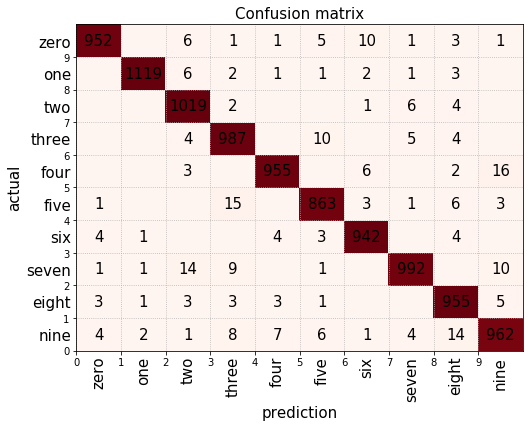

In [18]:
classes = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
confusion_matrix = np.zeros((num_classes, num_classes), np.int32)

for i in range(len(pred)):
    confusion_matrix[Yte[i]][pred[i]] += 1

fig, ax = plt.subplots(figsize=(8, 6))
plot_confusion_matrix(ax, confusion_matrix, classes, fontsize=15)

* Current world record: 0.21% error from *ensemble* of 5 CNNs with data augmentation

*Romanuke, Vadim. "Parallel Computing Center (Khmelnitskiy, Ukraine) represents an ensemble of 5 convolutional neural networks which performs on MNIST at 0.21 percent error rate.". Retrieved 24 November 2016."*

* We can plot the activation maps of the following image as it passes through the network

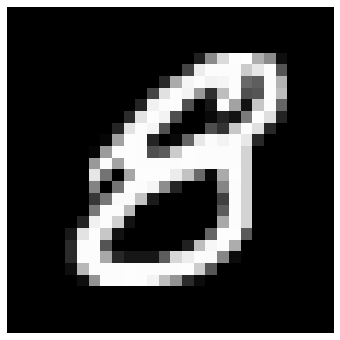

In [19]:
idx = np.random.randint(x_test.shape[0])

img = x_test[idx:idx+1]
fig, ax = plt.subplots(figsize=(6, 6))
vis_utils.plot_image(ax, img[0, ..., 0])

* First, the 32 activations of the first convolutional layer ($28 \times 28$ px)

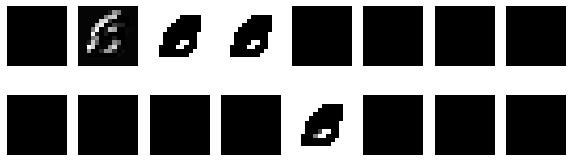

In [20]:
conv1 = Model(inputs=model.input, outputs=model.layers[3].output)

fig = plt.figure(figsize=(10, 3))
vis_utils.plot_activation_maps(fig, conv1.predict(img), 2, 8)
plt.show()

Then, the 64 activations of the second convolutional layer ($14 \times 14$ px)

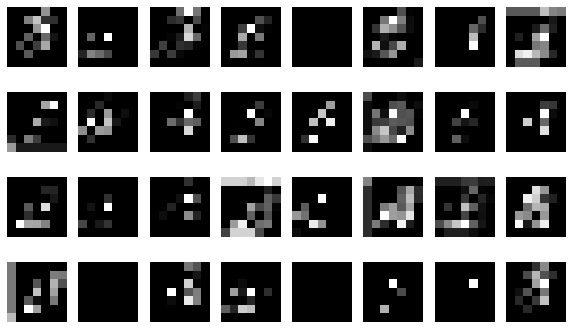

In [21]:
conv2 = Model(inputs=model.input, outputs=model.layers[6].output)

fig = plt.figure(figsize=(10, 6))
vis_utils.plot_activation_maps(fig, conv2.predict(img), 4, 8)
plt.show()

* For a live demo of activations in deep networks, see the Deep Visualisation Toolbox (https://www.youtube.com/watch?v=AgkfIQ4IGaM)